In [12]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym

class CEM(nn.Module):
    def __init__(self, state_dim, action_n, nn_size):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.network = nn.Sequential(nn.Linear(self.state_dim, nn_size),
                                     nn.ReLU(),
                                     nn.Linear(nn_size, self.action_n)
                                     )
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-2)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, _input):
        return self.network(_input)
        
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = self.softmax(logits).data.numpy()
        action = np.random.choice(self.action_n, p = probs)
        return action
    
    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)
                
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        pred_actions = self.forward(elite_states)
        
        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def get_trajectory(self, env, max_len=1000):
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()

        for _ in range(max_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            
            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)
        
            if done:
                break
        
        return trajectory
        
    def learn_agent(self, env, iteration_n, trajectory_n, q_param = 0.9):
        
        rewards = []
        
        for iteration in range(iteration_n):

            #policy evaluation
            trajectories = [self.get_trajectory(env) for _ in range(trajectory_n)]
            total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]

            print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))
            rewards.append(np.mean(total_rewards))
            
            #policy improvement
            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = []
            for trajectory in trajectories:
                total_reward = np.sum(trajectory['rewards'])
                if total_reward > quantile:
                    elite_trajectories.append(trajectory)
                    
            if len(elite_trajectories) > 0:
                self.fit(elite_trajectories)
        
        return rewards
        



class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim, nn_size):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, nn_size)
        self.linear_2 = nn.Linear(nn_size, int(nn_size / 2))
        self.linear_3 = nn.Linear(int(nn_size / 2), action_dim)
        self.activation = nn.ReLU()

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

class DQN:
    def __init__(self, state_dim, action_dim, nn_size, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim, nn_size)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state):
        q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values)
        probs = self.epsilon * np.ones(self.action_dim) / self.action_dim
        probs[argmax_action] += 1 - self.epsilon
        action = np.random.choice(np.arange(self.action_dim), p=probs)
        return action
    
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
                
    def learn_agent(self, env, episode_n, t_max):
        
        rewards = []
        
        for i in range(episode_n):
            total_reward = 0

            state = env.reset()
            for t in range(t_max):
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)

                total_reward += reward
                
                self.fit(state, action, reward, done, next_state)

                state = next_state

                if done:
                    break
                
            rewards.append(total_reward)
            
            if i % 10 == 0:
                print(f'episode: {i}, total_reward: {total_reward}')
            
        return rewards

In [21]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

max_reward = -150
best_params = {'episode_n': 100,
              't_max': 500,
              'nn_size': 128,
              'batch_size': 64}

parameters_chose = {'episode_n': np.arange(100, 400, 100),
                    't_max': np.arange(500, 2500, 500),
                    'nn_size': np.arange(128, 640, 128),
                    'batch_size': np.arange(128, 640, 128)}

for key in parameters_chose.keys():
    print(f"Testing - {key}")
    for param in parameters_chose[key]:
        agent = DQN(state_dim, action_dim, nn_size = best_params['nn_size'], batch_size = best_params['batch_size'])
        rewards = agent.learn_agent(env=env, episode_n=best_params['episode_n'], t_max=best_params['t_max'])
        
        if rewards[-1] > max_reward:
            max_reward = rewards[-1]
            best_params[key] = param
    print(f"Finished {key}, parameters: {best_params}")
    
print(f"Final parameters: {best_params}")

# Final parameters: {'episode_n': 200, 't_max': 1000, 'nn_size': 128, 'batch_size': 64}

Testing - episode_n
episode: 0, total_reward: -500.0
episode: 10, total_reward: -185.0
episode: 20, total_reward: -150.0
episode: 30, total_reward: -156.0
episode: 40, total_reward: -120.0
episode: 50, total_reward: -276.0
episode: 60, total_reward: -133.0
episode: 70, total_reward: -75.0
episode: 80, total_reward: -125.0
episode: 90, total_reward: -137.0
episode: 0, total_reward: -500.0
episode: 10, total_reward: -115.0
episode: 20, total_reward: -272.0
episode: 30, total_reward: -95.0
episode: 40, total_reward: -164.0
episode: 50, total_reward: -116.0
episode: 60, total_reward: -138.0
episode: 70, total_reward: -137.0
episode: 80, total_reward: -119.0
episode: 90, total_reward: -71.0
episode: 0, total_reward: -500.0
episode: 10, total_reward: -130.0
episode: 20, total_reward: -173.0
episode: 30, total_reward: -184.0
episode: 40, total_reward: -286.0
episode: 50, total_reward: -180.0
episode: 60, total_reward: -143.0
episode: 70, total_reward: -157.0
episode: 80, total_reward: -145.0


In [13]:
best_params = {'episode_n': 200, 't_max': 1000, 'nn_size': 128, 'batch_size': 64}
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = CEM(state_dim, action_dim, best_params['nn_size'])
cem_rewards = agent.learn_agent(env, iteration_n = 10, trajectory_n = 20, q_param = 0.9)

iteration: 0 mean total reward: -500.0
iteration: 1 mean total reward: -489.65
iteration: 2 mean total reward: -278.85
iteration: 3 mean total reward: -225.9
iteration: 4 mean total reward: -159.1
iteration: 5 mean total reward: -128.55
iteration: 6 mean total reward: -111.0
iteration: 7 mean total reward: -104.7
iteration: 8 mean total reward: -118.8
iteration: 9 mean total reward: -108.0


In [14]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim, nn_size = best_params['nn_size'], batch_size = best_params['batch_size'])
dqn_rewards = agent.learn_agent(env=env, episode_n=best_params['episode_n'], t_max=best_params['t_max'])

episode: 0, total_reward: -500.0
episode: 10, total_reward: -111.0
episode: 20, total_reward: -111.0
episode: 30, total_reward: -142.0
episode: 40, total_reward: -157.0
episode: 50, total_reward: -122.0
episode: 60, total_reward: -123.0
episode: 70, total_reward: -139.0
episode: 80, total_reward: -228.0
episode: 90, total_reward: -176.0
episode: 100, total_reward: -120.0
episode: 110, total_reward: -148.0
episode: 120, total_reward: -110.0
episode: 130, total_reward: -113.0
episode: 140, total_reward: -108.0
episode: 150, total_reward: -114.0
episode: 160, total_reward: -81.0
episode: 170, total_reward: -82.0
episode: 180, total_reward: -115.0
episode: 190, total_reward: -193.0


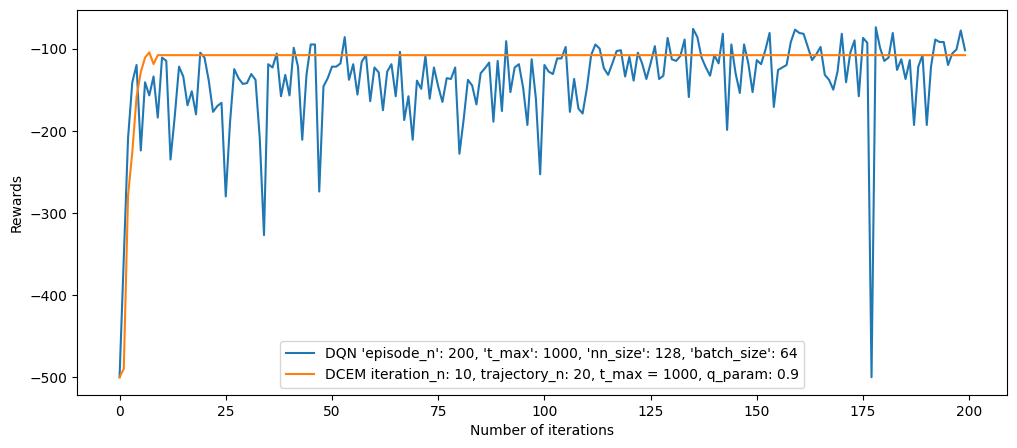

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)

plt.plot(dqn_rewards, label = f"DQN 'episode_n': 200, 't_max': 1000, 'nn_size': 128, 'batch_size': 64")
plt.plot(np.concatenate([cem_rewards, np.repeat(cem_rewards[-1], len(dqn_rewards) - len(cem_rewards))]), label = f"DCEM iteration_n: 10, trajectory_n: 20, t_max = 1000, q_param: 0.9")
plt.ylabel("Rewards")
plt.xlabel("Number of iterations")
plt.legend(loc = 'best')